<a href="https://colab.research.google.com/github/KirtiNayak11/NLP/blob/main/LSTM_Based_Poetry_Generation.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow.keras.utils as ku
from wordcloud import WordCloud
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

Building the Text Generator

Step 1. Import Necessary Libraries

In [ ]:
import numpy as np
import pandas as pd
import matplotlib.pyplot as plt
import tensorflow.keras.utils as ku
from wordcloud import WordCloud
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.text import Tokenizer
from tensorflow.keras.models import Sequential
from tensorflow.keras.optimizers import Adam
from tensorflow.keras import regularizers

Step 2. Loading the Dataset and Exploratory Data Analysis

Now, we’ll load our dataset using pandas. Further, we need to perform some Exploratory Data Analysis so that we get to know our data better. As we are dealing with text data, the best way to do so is by generating a word cloud.

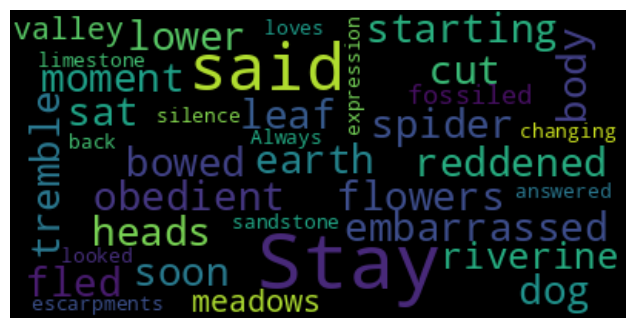

In [ ]:
# Reading the text data file
data = open('/content/drive/MyDrive/DataScience/NLP/RNN/LSTM Based Poetry Generation/poem.txt', encoding="utf8").read()

# EDA: Generating WordCloud to visualize
# the text
wordcloud = WordCloud(max_font_size=50,
					max_words=100,
					background_color="black").generate(data)

# Plotting the WordCloud
plt.figure(figsize=(8, 4))
plt.imshow(wordcloud, interpolation='bilinear')
plt.axis("off")
plt.savefig("WordCloud.png")
plt.show()

Step 3. Creating the Corpus

Now, we have all our data present in this massive text file. However, it is not recommended to feed our model with all the data altogether as it would lead to a lesser accuracy. Thus, we will be splitting our text into lines so that we can use them to generate text embeddings for our model.

In [ ]:
# Generating the corpus by
# splitting the text into lines
corpus = data.lower().split("\n")
print(corpus[:10])

['stay, i said', 'to the cut flowers.', 'they bowed', 'their heads lower.', 'stay, i said to the spider,', 'who fled.', 'stay, leaf.', 'it reddened,', 'embarrassed for me and itself. stay, i said to my body. it sat as a dog does, obedient for a moment, soon starting to tremble. stay, to the earth', 'of riverine valley meadows, of fossiled escarpments,']


Step 4. Fitting the Tokenizer on the Corpus

In order to generate the embeddings later, we need to fit a TensorFlow Tokenizer on the entire corpus so that it learns the vocabulary.  

In [ ]:
tokenizer = Tokenizer()
tokenizer.fit_on_texts(corpus)

total_words = len(tokenizer.word_index)

print(total_words)

55


In [ ]:
input_sequences=[]
for line in corpus:
  token_list = tokenizer.texts_to_sequences([line])[0]
  input_sequences.append(token_list)

print(input_sequences)

[[1, 3, 4], [2, 5, 12, 13], [14, 15], [16, 17, 18], [1, 3, 4, 2, 5, 19], [20, 21], [1, 22], [6, 23], [24, 9, 25, 10, 26, 1, 3, 4, 2, 11, 27, 6, 28, 29, 7, 30, 31, 32, 9, 7, 33, 34, 35, 2, 36, 1, 2, 5, 37], [8, 38, 39, 40, 8, 41, 42], [8, 43, 10, 44], [6, 45, 46], [47, 7, 48, 49, 50, 51, 1, 3, 4, 2, 11, 52], [53, 54], [55]]


In [ ]:
for line in corpus:
  token_list = tokenizer.texts_to_sequences([line])
  print(token_list)

[[1, 3, 4]]
[[2, 5, 12, 13]]
[[14, 15]]
[[16, 17, 18]]
[[1, 3, 4, 2, 5, 19]]
[[20, 21]]
[[1, 22]]
[[6, 23]]
[[24, 9, 25, 10, 26, 1, 3, 4, 2, 11, 27, 6, 28, 29, 7, 30, 31, 32, 9, 7, 33, 34, 35, 2, 36, 1, 2, 5, 37]]
[[8, 38, 39, 40, 8, 41, 42]]
[[8, 43, 10, 44]]
[[6, 45, 46]]
[[47, 7, 48, 49, 50, 51, 1, 3, 4, 2, 11, 52]]
[[53, 54]]
[[55]]


In [ ]:
# Converting the text into embeddings
input_sequences = []
for line in corpus:
	token_list = tokenizer.texts_to_sequences([line])[0]

	for i in range(1, len(token_list)):
		n_gram_sequence = token_list[:i+1]
		input_sequences.append(n_gram_sequence)

max_sequence_len = max([len(x) for x in input_sequences])
input_sequences = np.array(pad_sequences(input_sequences,
										maxlen=max_sequence_len,
										padding='pre'))
predictors, label = input_sequences[:, :-1], input_sequences[:, -1]
label = ku.to_categorical(label, num_classes=total_words+1)

In [ ]:
print(predictors)

[[ 0  0  0 ...  0  0  1]
 [ 0  0  0 ...  0  1  3]
 [ 0  0  0 ...  0  0  2]
 ...
 [ 0  0  0 ...  3  4  2]
 [ 0  0  0 ...  4  2 11]
 [ 0  0  0 ...  0  0 53]]


In [ ]:
print(label)

[[0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 ...
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 0. 0.]
 [0. 0. 0. ... 0. 1. 0.]]


Step 6. Building the Bi-directional LSTM Model

By now, we are done with all the pre-processing steps that were required in order to feed the text to our model. Its time now that we start building the model. Since this is a use case of text generation, we will create a Bi-directional LSTM model as meaning plays an important role here.

In [ ]:
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding, LSTM, Dense, Dropout, Bidirectional
from tensorflow.keras.preprocessing.sequence import pad_sequences
from tensorflow.keras import regularizers
import numpy as np

# Define Model
model = Sequential()

# Add Embedding Layer
model.add(Embedding(input_dim=total_words+1, output_dim=100, input_length=max_sequence_len-1))

# Bi-Directional LSTM Layer
model.add(Bidirectional(LSTM(150, return_sequences=True)))

# Dropout Layer
model.add(Dropout(0.2))

# Second LSTM Layer
model.add(LSTM(100))

# Fully Connected Layer with Regularization
model.add(Dense((total_words+1) // 2, activation='relu',
                kernel_regularizer=regularizers.l2(0.01)))

# Output Layer
model.add(Dense(total_words+1, activation='softmax'))

# Compile Model
model.compile(loss='categorical_crossentropy', optimizer='adam', metrics=['accuracy'])

# **Force Model to Build**
model.build(input_shape=(None, max_sequence_len-1))

# Print Model Summary
print(model.summary())


/usr/local/lib/python3.11/dist-packages/keras/src/layers/core/embedding.py:90: UserWarning: Argument `input_length` is deprecated. Just remove it.
  warnings.warn(


Model: "sequential_3"

┏━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━━━━━━━━━━━━━┳━━━━━━━━━━━━━━━━━┓
┃ Layer (type)                         ┃ Output Shape                ┃         Param # ┃
┡━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━━━━━━━━━━━━━╇━━━━━━━━━━━━━━━━━┩
│ embedding_3 (Embedding)              │ (None, 28, 100)             │           5,600 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ bidirectional_3 (Bidirectional)      │ (None, 28, 300)             │         301,200 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dropout_3 (Dropout)                  │ (None, 28, 300)             │               0 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ lstm_7 (LSTM)                        │ (None, 100)                 │         160,400 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_6 (Dense)                      │ (None, 28)                  │           2,828 │
├──────────────────────────────────────┼─────────────────────────────┼─────────────────┤
│ dense_7 (Dense)                      │ (None, 56)                  │           1,624 │
└──────────────────────────────────────┴─────────────────────────────┴─────────────────┘

 Total params: 471,652 (1.80 MB)

 Trainable params: 471,652 (1.80 MB)

 Non-trainable params: 0 (0.00 B)

None


In [ ]:
history = model.fit(predictors, label, epochs=150, verbose=1)

Epoch 1/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 7s 112ms/step - accuracy: 0.0114 - loss: 4.4655
Epoch 2/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 110ms/step - accuracy: 0.0306 - loss: 4.4371
Epoch 3/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 112ms/step - accuracy: 0.0266 - loss: 4.4012
Epoch 4/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 125ms/step - accuracy: 0.0227 - loss: 4.3632
Epoch 5/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 113ms/step - accuracy: 0.0497 - loss: 4.3377
Epoch 6/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 119ms/step - accuracy: 0.0497 - loss: 4.3057
Epoch 7/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 0s 110ms/step - accuracy: 0.0877 - loss: 4.2773
Epoch 8/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.0533 - loss: 4.2858
Epoch 9/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 118ms/step - accuracy: 0.0611 - loss: 4.2445
Epoch 10/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 192ms/step - accuracy: 0.0533 - loss: 4.2476
Epoch 11/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 223ms/step - accuracy: 0.0529 - loss: 4.2004
Epoch 12/150
3/3 ━━━━━━━━━━━━━━━━━━━━ 1s 224ms/step - accuracy:

In [ ]:
seed_text = "The world"
next_words = 25
ouptut_text = ""

for _ in range(next_words):
	token_list = tokenizer.texts_to_sequences([seed_text])[0]
	token_list = pad_sequences(
		[token_list], maxlen=max_sequence_len-1,
	padding='pre')
	predicted = np.argmax(model.predict(token_list,
										verbose=0), axis=-1)
	output_word = ""

	for word, index in tokenizer.word_index.items():
		if index == predicted:
			output_word = word
			break

	seed_text += " " + output_word

print(seed_text)


The world lower lower lower a silence stay i said my loves loves loves a sat a does obedient a moment soon starting to tremble tremble tremble


In [ ]:
import numpy as np
from tensorflow.keras.preprocessing.sequence import pad_sequences

seed_text = "The world"
next_words = 25

for _ in range(next_words):
    token_list = tokenizer.texts_to_sequences([seed_text])[0]
    token_list = pad_sequences([token_list], maxlen=max_sequence_len-1, padding='pre')

    # Use temperature-based sampling instead of argmax
    preds = model.predict(token_list, verbose=0)[0]
    predicted = np.random.choice(len(preds), p=preds)  # Random selection based on probability

    output_word = ""
    for word, index in tokenizer.word_index.items():
        if index == predicted:
            output_word = word
            break

    seed_text = " ".join(seed_text.split()[-(max_sequence_len-1):]) + " " + output_word

print(seed_text)

The world to lower lower for loves itself stay the said to to my sandstone loves loves tremble stay the my stay the spider to the to


explain embedding with some example?- how do we decide output dim
ChatGPT said:
Understanding the Embedding Layer in Deep Learning
The Embedding layer is used to represent words as dense vectors in a continuous space. This helps neural networks process words more effectively.

1️⃣ What is an Embedding Layer?
It converts integer-based word indices (tokens) into dense vectors of fixed size.
These vectors capture semantic relationships between words.
Instead of using one-hot encoding (which is sparse and high-dimensional), embeddings reduce dimensionality and improve learning.
2️⃣ Example Without Embedding
Suppose we have three words:
📌 ["king", "queen", "prince"]

A naive one-hot encoding representation would be:

css
Copy
Edit
king   → [1, 0, 0]  
queen  → [0, 1, 0]  
prince → [0, 0, 1]
🔴 Problems with One-Hot Encoding:

No relationship between words.
Requires huge vectors for large vocabularies.
Inefficient for training neural networks.
3️⃣ Example With Embedding
With an embedding layer (e.g., output_dim=3), the words are mapped to dense vectors:

css
Copy
Edit
king   → [ 0.12,  0.55, -0.32]  
queen  → [-0.44,  0.22,  0.73]  
prince → [ 0.36, -0.15,  0.92]
✅ Benefits of Embeddings:

Captures word relationships (e.g., "king" and "queen" are closer than "king" and "car").
Reduces dimensionality.
Enhances model efficiency.
4️⃣ Code Example: Using an Embedding Layer
python
Copy
Edit
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding

# Example Vocabulary (word indices)
vocab_size = 6  # Suppose we have 6 unique words
output_dim = 3  # Embedding size (each word is mapped to a 3D vector)
input_length = 1  # Each input is a single word

# Create a simple model with an Embedding layer
model = Sequential([
    Embedding(input_dim=vocab_size, output_dim=output_dim, input_length=input_length)
])

# Sample input (word index representation)
sample_input = np.array([[2]])  # Assume '2' represents the word 'king'

# Get the embedding output
embedding_output = model.predict(sample_input)
print(embedding_output)  # A 3D vector for 'king'
Output:

lua
Copy
Edit
[[[ 0.12,  0.55, -0.32 ]]]  # Example embedding vector for word index 2
5️⃣ How to Choose output_dim in Embedding?
python
Copy
Edit
Embedding(input_dim=vocab_size, output_dim=embedding_size, input_length=max_sequence_len-1)
Guidelines for Choosing output_dim:
Small datasets (≤ 10,000 words) → output_dim = 50 to 100
Medium datasets (10k - 100k words) → output_dim = 100 to 300
Large datasets (100k+ words) → output_dim = 300 to 600
Very large datasets (BERT, GPT models) → output_dim = 768 to 1024
💡 Rule of Thumb:
For most NLP tasks, 50-300 dimensions work well.

6️⃣ Pretrained Embeddings (Word2Vec, GloVe)
Instead of training embeddings from scratch, you can use pretrained embeddings like:

Word2Vec
GloVe
FastText
🔹 Example: Using Pretrained GloVe Embeddings

python
Copy
Edit
embedding_matrix = np.zeros((vocab_size, output_dim))
for word, index in tokenizer.word_index.items():
    if word in glove_dict:  # Pre-trained GloVe vectors
        embedding_matrix[index] = glove_dict[word]

model.add(Embedding(input_dim=vocab_size, output_dim=100,
                    weights=[embedding_matrix], trainable=False))
This loads pre-trained vectors and freezes them.

7️⃣ Summary
✅ The Embedding layer maps words to dense vectors.
✅ It captures semantic relationships between words.
✅ output_dim decides vector size (usually 50-300).
✅ You can train embeddings or use pretrained embeddings (GloVe, Word2Vec).

Would you like a visualization of embeddings using t-SNE or PCA? 😊







You said:
here -? what is output dimension?-output_dim
ChatGPT said:
What is output_dim in the Embedding Layer?
In the Embedding layer of a neural network, output_dim refers to the size of the word vectors (i.e., the number of dimensions each word is mapped to).

Formula:
python
Copy
Edit
Embedding(input_dim=vocab_size, output_dim=embedding_size, input_length=max_sequence_len-1)
🔹 output_dim (or embedding_size) is the number of features in the word representation.
🔹 It determines how much information is captured about each word.

🔹 Example: Understanding output_dim
Suppose we have a vocabulary of 6 words and set:

python
Copy
Edit
Embedding(input_dim=6, output_dim=3, input_length=1)
Each word will be represented as a vector of size 3.
If "king" is mapped to index 2, it will have a 3D embedding vector:
css
Copy
Edit
king → [ 0.12,  0.55, -0.32 ]
queen → [-0.44,  0.22,  0.73 ]
prince → [ 0.36, -0.15,  0.92 ]
These values are learned during training.
🔹 How Do We Choose output_dim?
Dataset Size	Recommended output_dim
Small datasets (≤ 10,000 words)	50 to 100
Medium datasets (10k - 100k words)	100 to 300
Large datasets (100k+ words)	300 to 600
Deep models (BERT, GPT)	768 to 1024
Rule of Thumb:
If you set it too low, the model won't capture enough information.
If you set it too high, it may overfit (especially for small datasets).
🔹 Example Code with output_dim
python
Copy
Edit
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding

# Define embedding layer with output_dim=4
model = Sequential([
    Embedding(input_dim=6, output_dim=4, input_length=1)
])

# Sample input (word index representation)
sample_input = np.array([[2]])  # Suppose '2' represents "king"

# Get the embedding output
embedding_output = model.predict(sample_input)
print(embedding_output)  # Outputs a 4D vector for word index 2
Example Output:

lua
Copy
Edit
[[[ 0.12,  0.55, -0.32,  0.78 ]]]  # Learned embedding for 'king'
💡 Each word gets a vector of length 4 because output_dim=4.

🔹 Final Summary
✅ output_dim defines the size of word vectors.
✅ Larger values capture more meaning but need more data.
✅ Typical range: 50-300 for most NLP tasks.
✅ Pretrained embeddings (Word2Vec, GloVe) use fixed dimensions (e.g., 300 for GloVe).

Would you like help choosing the best output_dim for your dataset? 😊







You said:
here input dim is numberof words?-input_dim=6
ChatGPT said:
What is input_dim in the Embedding Layer?
Yes! input_dim represents the total number of unique words (vocabulary size) in your dataset.

🔹 Explanation
python
Copy
Edit
Embedding(input_dim=6, output_dim=4, input_length=1)
input_dim=6 → This means there are 6 unique words in your vocabulary.
output_dim=4 → Each word is represented as a 4D dense vector.
input_length=1 → Each input contains 1 word at a time.
🔹 Example
Step 1: Assume a vocabulary of 6 words
Word	Index
king	1
queen	2
prince	3
apple	4
banana	5
cat	6
Step 2: The Embedding Layer Converts Words into Vectors
The model assigns a random vector (which will be learned during training) to each word:

css
Copy
Edit
king    → [ 0.12,  0.55, -0.32,  0.78 ]  
queen   → [-0.44,  0.22,  0.73, -0.91 ]  
prince  → [ 0.36, -0.15,  0.92,  0.11 ]  
apple   → [ 0.87, -0.67,  0.21, -0.34 ]  
banana  → [-0.99,  0.43, -0.76,  0.88 ]  
cat     → [ 0.65, -0.33,  0.59, -0.41 ]  
🔹 Code Example
python
Copy
Edit
import numpy as np
from tensorflow.keras.models import Sequential
from tensorflow.keras.layers import Embedding

# Define the embedding layer
model = Sequential([
    Embedding(input_dim=6, output_dim=4, input_length=1)  # 6 words, 4D vectors
])

# Example input (word index for "queen" → 2)
sample_input = np.array([[2]])  

# Get the embedding output
embedding_output = model.predict(sample_input)
print(embedding_output)  # Output: A 4D vector for the word at index 2
🔹 If the input is 2 ("queen"), the output will be a learned 4D vector.

🔹 Summary
✅ input_dim = Total number of unique words (vocabulary size).
✅ Each word is assigned a unique index (1 to input_dim).
✅ The embedding layer converts these indices into dense vectors of size output_dim.
✅ Higher input_dim means a larger vocabulary and more memory usage.

Would you like help in handling larger vocabularies efficiently? 😊

In [ ]:
Why is output_dim = 100 used in embeddings?
In an embedding layer, output_dim represents the size of the dense vector space where words are mapped. Choosing output_dim = 100 means each word in your vocabulary will be represented by a 100-dimensional vector.

It is a hyperparameter, and its choice depends on:

Vocabulary size (total_words in your case).
Dataset size (more data → larger dimensions help capture meaning).
Model complexity (higher values increase computational cost).
Performance trade-off (larger embeddings might work better but need more memory).
A common choice:

50-100 dimensions for small datasets.
200-300 dimensions for moderate-sized corpora.
300+ dimensions for large datasets like Wikipedia.